# Preparatory steps
### Setup the insertion to work with, the imports and inits.

In [33]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from brainbox.ephys_plots import plot_brain_regions
import numpy as np
from ibllib.plots.misc import Density
import matplotlib.pyplot as plt
from ibldsp.voltage import destripe
from viewephys.gui import viewephys
from iblatlas.atlas import BrainRegions

one = ONE()
regions = BrainRegions()

# pid for a good insertion
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'

# Instantiate spike sorting loader
ssl = SpikeSortingLoader(pid=pid, one=one)

### Get the raw data snippet
Here we load and destripe 0.09 seconds of raw data, at 100 seconds in the recording. You can choose a different time point or duration.

It is recommended to check at multiple time points in your recording, evenly spaced out, e.g. at 10-30-50 minutes in a recording if it lasts 1h.

In [34]:
# Get AP spikeglx.Reader objects
sr_ap = ssl.raw_electrophysiology(band="ap")

# Load the raw data snippet and destripe it
t0 = 100  # Seconds in the recording
s0 = int(sr_ap.fs * t0)
dur = int(0.09 * sr_ap.fs)  # We take 0.09 second of data
raw_ap = sr_ap[s0:s0 + dur, :-sr_ap.nsync].T
destriped = destripe(raw_ap, sr_ap.fs)

### Get the spike sorted data
Load all the spike sorted data first.

In [35]:
# Get spikes, especially the samples to align it with the raw data
spikes, clusters, channels = ssl.load_spike_sorting(dataset_types=["spikes.samples"], revision="2024-05-06")

Then restrict the spikes to those only in the raw data snippet.

In [36]:
# Get the spikes that are within this raw data snippet
spike_selection = slice(*np.searchsorted(spikes.samples, [s0, s0 + dur]))
su = spikes.clusters[spike_selection]
sc = clusters.channels[spikes.clusters][spike_selection]
ss = (spikes.samples[spike_selection] - s0) / sr_ap.fs * 1e3

Get the spikes from good or bad units.

In [37]:
clusters_good = np.where(clusters.metrics.label == 1)[0]
clusters_bad = np.where(clusters.metrics.label != 1)[0]

inds_good = np.isin(su, clusters_good)
inds_bad = np.isin(su, clusters_bad)
        
sc_good = sc[inds_good]
sc_bad = sc[inds_bad]
ss_good = ss[inds_good]
ss_bad = ss[inds_bad]

### Display the data
Below we present two options to diplay the data, but the second option is only if you do not manage to use viewephys and is not recommended.

We will plot all the spikes (from both good and bad units, in green and red respectively).

#### 1 - Viewephys
We display here multiple views of the data:
- raw data
- destriped data
- destriped data with spikes overlaid (green: good cluster, red: bad clusters)

You can shift across windows using your system OS keyboard shortcuts, such as command+> on Mac. This enables you to see what changes across the different windows, here displaying processing stages. 

You can zoom in (scroll your mouse), or pan (click-hold and move your mouse). Once settled on a particular view of interest, use command+P to set all the windows to the same view settings as the current one.

In [38]:
# Display using viewephys
evs = {}
# Window to see the raw data, prior to destriping
evs['ap_raw'] = viewephys(data=raw_ap, fs=sr_ap.fs, channels=channels, br=regions, title='ap_raw')
# Window to see the destriped data alone
evs['ap_destripe'] = viewephys(data=destriped, fs=sr_ap.fs, channels=channels, br=regions, title='ap_destriped')
# Window to see the destriped data, onto which we overlay the spikes detected
evs['ap_des_clu'] = viewephys(data=destriped, fs=sr_ap.fs, channels=channels, br=regions, title='ap_destriped_clus')
evs['ap_des_clu'].ctrl.add_scatter(ss_bad, sc_bad, rgb=(255, 0, 0), label='bad clusters')
evs['ap_des_clu'].ctrl.add_scatter(ss_good, sc_good, rgb=(0, 255, 0), label='good clusters')
%gui qt

#### 2 - Density plot (not recommended)
Use this only if you struggle with viewephys. In this view, we show only the destriped data, not the raw.
We display spikes from good and bad units using green and red dots respectively.

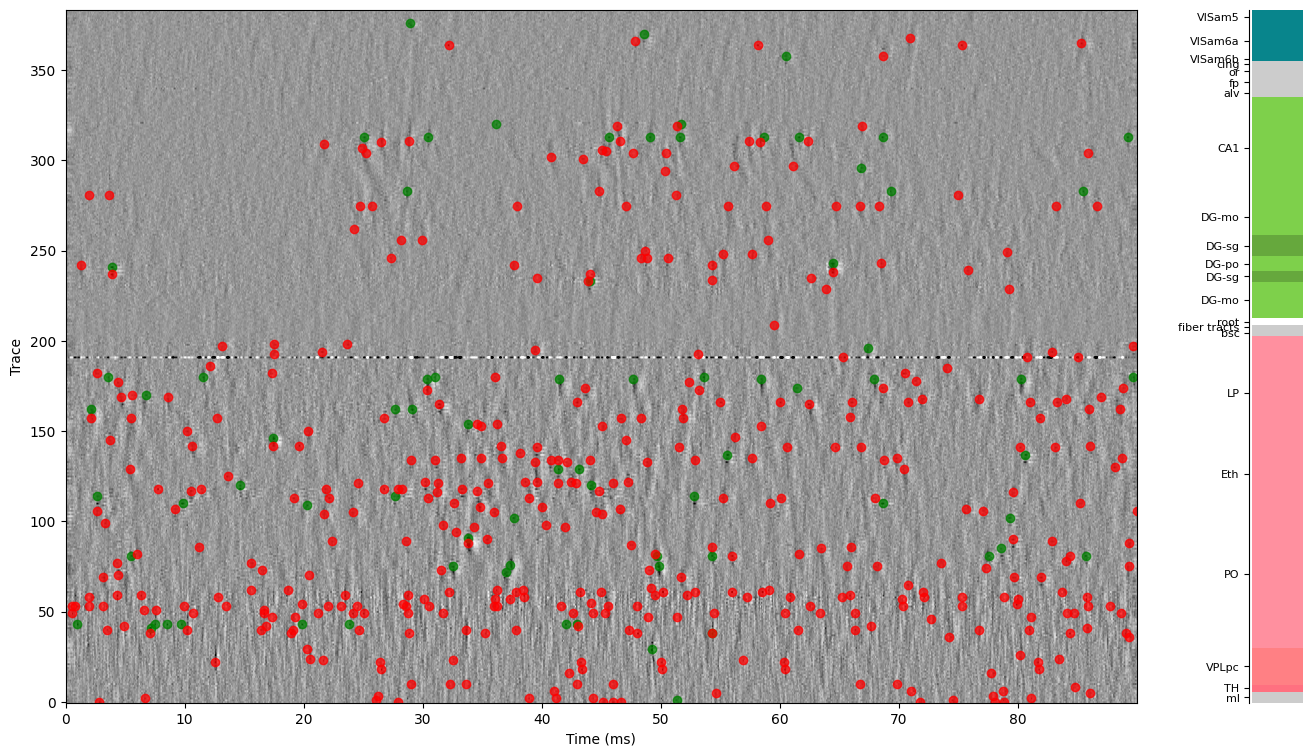

In [43]:
# Display using Density
fig, axs = plt.subplots(1, 2, gridspec_kw={
    'width_ratios': [.95, .05]}, figsize=(16, 9), sharex='col')
# You could change the variable to "raw_ap" if you wanted to see the raw data, using gain=-85.
Density(destriped, fs=sr_ap.fs, taxis=1, gain=-91., ax=axs[0])
# We display goog units in green, bad units in red
axs[0].scatter(ss_good, sc_good, color="green", alpha=0.75)
axs[0].scatter(ss_bad, sc_bad, color="red", alpha=0.75)

# Plot brain regions in another column
plot_brain_regions(channels["atlas_id"], channel_depths=channels["axial_um"], ax = axs[1], display=True)

plt.show()

# Step 1 : Check the quality of the raw data
On the **raw data** 
- Does this look like neural activity to you? Do you notice any signals leaking into the AP band ? 
- What is the origin of the large black and white oscillations visible near the dentate gyrus ?
- Can you see the vertical stripes, and how they disappear after destriping?

On the **destriped data**, do you see any sign of:
- Saturation
- Bad channel
- Noise


# Step 2 : Check the quality of spike detection
As part of this exercise, try to :
- zoom in onto a spike of interest
- use command+p to set all the windows to the same settings
- navigate across the windows (raw, destriped and destriped + clusters) 

Do you see any
- Spikes that are visible on the raw data but not detected (missed)
- Spike detected multiple times (duplication)
- Artefacts or noise which are detected as spikes (wrong detection)


# Step 3 : Check the quality of spike sorting

Do you see any
- Spikes that are clearly visible, but are being assigned to a bad unit (red)
- Spikes that you can track by eyes as belonging to one good unit ; are some of these spikes rejected

Would you analyse the rejected spikes? Do you believe they contain information reflecting neural activity ?